In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
from neural_circuits.SC_Circuit_4 import SC_acc, SC_acc_var, SC_sim, unwrap, SC_acc_diff
import seaborn as sns
import os


### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 5. 

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)
"""sW = Parameter("sW", 1, lb=-2., ub=1.)
vW = Parameter("vW", 1, lb=-5., ub=-2.)
dW = Parameter("dW", 1, lb=-4., ub=1.)
hW = Parameter("hW", 1, lb=-2., ub=-.5)"""

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit", parameters)

### 2. Define eps function using Euler

In [3]:
model.set_eps(SC_acc)

def accept_inds(T_x, means, stds):
    acc = np.array([np.logical_and(means[i] - 2*stds[i] < T_x[:,i], 
                    T_x[:,i] < means[i] + 2*stds[i]) for i in range(len(means))])
    return np.logical_and.reduce(acc, axis=0)
                          

In [6]:
import time
num_keep = 500
M = 1000
zs = []
T_xs = []

p = .75
means = [p, 1-p]
stds = [0.075, 0.075]

_round = 0
num_found = 0
z = None
T_x = None
times = []
while (num_found < num_keep):
    _round += 1
    time1 = time.time()
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    time2 = time.time()
    round_time = time2-time1
    print('r%d %d/%d %.1f s, total time %.2f mins\r' % (_round, num_found, num_keep, round_time, sum(times)/60.), end='')
    times.append(round_time)
    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20

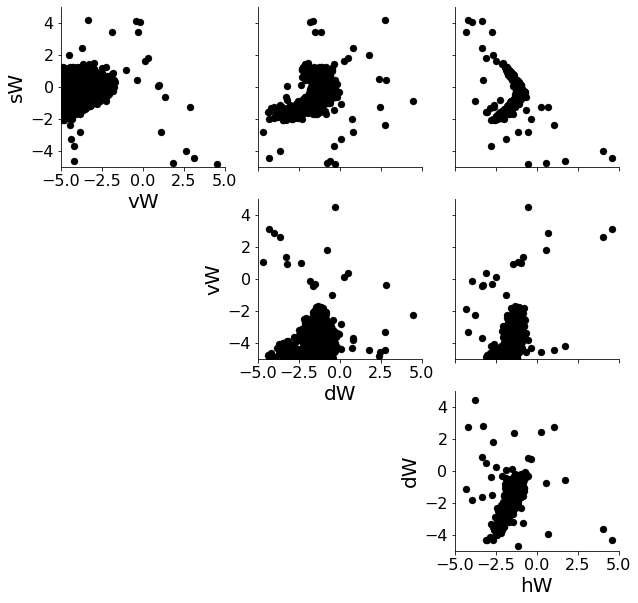

In [23]:
z_labels = [p.name for p in model.parameters]
#z_star = np.mean(z, axis=0)[None,:]

_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
fig = pairplot(z, np.arange(4), z_labels, lb=lb*np.ones((4,)), ub=ub*np.ones((4,)),
               fontsize=fontsize, figsize=(10,10))

In [8]:
T_x_sim = model.eps(z).numpy()

[[0.8745625  0.27631903]
 [0.90188813 0.35999936]
 [0.86393523 0.1447578 ]
 [0.6466678  0.345     ]
 [0.6646985  0.3674176 ]
 [0.48       0.54      ]
 [0.6991937  0.3465741 ]
 [0.7041193  0.3250827 ]
 [0.7742169  0.3311811 ]
 [0.5969512  0.3807782 ]
 [0.6890514  0.11991518]
 [0.75322235 0.3096529 ]
 [0.66849446 0.17325653]
 [0.83597106 0.21766743]
 [0.73128927 0.30350044]
 [0.6937001  0.20831674]
 [0.63604486 0.1003602 ]
 [0.683503   0.39545554]
 [0.6752121  0.27471116]
 [0.67569685 0.16933745]
 [0.7794617  0.345     ]
 [0.6703759  0.2852558 ]
 [0.6553317  0.09924579]
 [0.6058478  0.2736519 ]
 [0.6452391  0.28817004]
 [0.88335985 0.05614593]
 [0.72444314 0.34835023]
 [0.620249   0.29934233]
 [0.6501062  0.25565773]
 [0.6573408  0.36893326]
 [0.8352739  0.34812587]
 [0.734285   0.12474895]
 [0.6102758  0.1929705 ]
 [0.64479554 0.2924429 ]
 [0.7589215  0.14056763]
 [0.7197614  0.3143591 ]
 [0.86110145 0.21      ]
 [0.7077028  0.27681005]
 [0.7644214  0.37406963]
 [0.5602316  0.1258724 ]


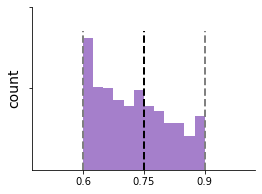

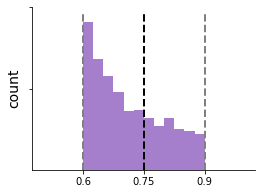

In [47]:
from epi.util import plot_T_x
bins = 20
ylims = [0, 100]
ax = plot_T_x(None, T_x[:,0], xmin=.5, xmax=1., bins=bins,
         x_mean = 0.75, x_std = 0.075, figsize=(4,3))
ax.set_yticks([50, 100])
ax = plot_T_x(None, 1.-T_x[:,1], xmin=.5, xmax=1., bins=bins,
         x_mean = 0.75, x_std = 0.075, figsize=(4,3))
ax.set_yticks([50, 100])

In [18]:
lb = -5.
ub = 5.
sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)
parameters = [sW, vW, dW, hW]
model = Model("SC_Circuit_var", parameters)
model.set_eps(SC_acc_var(p))

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]

mu_std = 0.075
mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df = epi_df[(epi_df['p']==p)
              & (epi_df['beta']==2.)
              & (epi_df['mu_std']==mu_std)
              & (epi_df['random_seed']==3)]
print(epi_df['path'].unique())

paths = sorted(epi_df['path'].unique())
path = paths[0]
best_k = 10

_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

['data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_affine_L2_U50_rs3/9c77288aa959be8e0bb41c88f1921f85/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00']


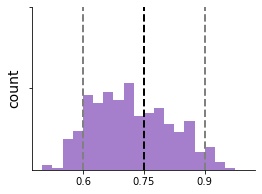

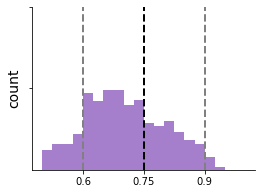

In [49]:
z_epi = dist(500)
T_x_epi = model.eps(z).numpy()
ax = plot_T_x(None, T_x_epi[:,0], xmin=.5, xmax=1., bins=bins,
         x_mean = 0.75, x_std = 0.075, figsize=(4,3), ylim=ylims)
ax.set_yticks([50, 100])
ax = plot_T_x(None, 1.-T_x_epi[:,1], xmin=.5, xmax=1., bins=bins,
         x_mean = 0.75, x_std = 0.075, figsize=(4,3), ylim=ylims)
ax.set_yticks([50, 100])


In [40]:
print([key for key in movie_data.keys()])

['zs', 'log_q_zs', 'time_per_it', 'iterations']


In [45]:
T_xi

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[5.07403970e-01, 4.67549562e-01, 5.88528328e-02, 4.73278128e-02],
       [8.28304470e-01, 4.33100499e-02, 6.13158988e-03, 4.27207388e-02],
       [5.00000000e-01, 5.00000000e-01, 6.25000000e-02, 6.25000000e-02],
       [5.00000000e-01, 5.00000000e-01, 6.25000000e-02, 6.25000000e-02],
       [9.04900312e-01, 1.10113017e-01, 2.39941068e-02, 1.95683651e-02],
       [5.79999983e-01, 5.09845555e-01, 2.89000049e-02, 6.75197095e-02],
       [8.37739885e-01, 5.03714643e-02, 7.69828726e-03, 3.98515500e-02],
       [9.19330835e-01, 7.80228823e-02, 2.86729317e-02, 2.95761283e-02],
       [8.60754550e-01, 5.52292354e-02, 1.22665698e-02, 3.79356518e-02],
       [5.00000000e-01, 4.99999434e-01, 6.25000000e-02, 6.24997169e-02],
       [7.78682530e-01, 3.94699365e-01, 8.22687522e-04, 2.09379066e-02],
       [9.66454327e-01, 3.75193745e-01, 4.68524769e-02, 1.56734735e-02],
       [9.07173932e-01, 7.84916729e-02, 2.47036442e-02, 2.94151064e-02],
 

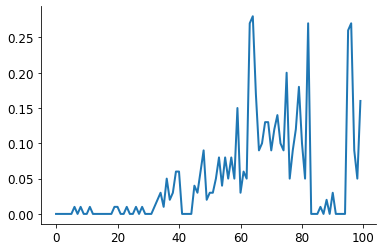

In [43]:
zs = movie_data['zs']

_n = zs.shape[0]
N = zs.shape[1]
accept_ratios = []
for i in range(N):
    print("%3d/%3d\r" % (i+1, N), end="")
    T_xi = model.eps(zs[i]) 
    inds = accept_inds(T_xi, means, stds) 
    accept_ratios.append(float(np.sum(inds)) / N)
plt.plot(accept_ratios)
    

0.6646862030029297


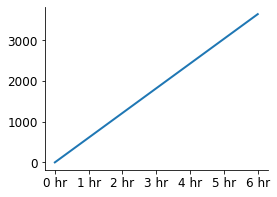

In [39]:
movie_data = np.load(os.path.join(path, 'movie_data.npz'))
opt_data = np.load(os.path.join(path, 'opt_data.npz'))
time_per_it = movie_data['time_per_it']
print(time_per_it)
abc_rate = 500. / sum(times)
seconds = np.linspace(0., 6*(60.*60.), 100)
xticks = 60.*60.*np.arange(0, 7)
xticklabels = ["%d hr" % x for x in range(7)]

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(seconds, abc_rate*seconds)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels);

